In [45]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [25]:
file_path = "extraction/data_censored.csv"

# Read the CSV file into a DataFrame
try:
    data_censored = pd.read_csv(file_path)
    print("Data loaded successfully!")
    print(data_censored.head())  # Display the first few rows
    print(data_censored.describe())
    # print(data_censored['age'].mean())
except FileNotFoundError:
    print(f"File not found at {file_path}")

Data loaded successfully!
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
               id      period   treatment          x1          x2          x3  \
count  725.000000  725.000000  725.000000  725.000000  725.000000  725.000000   
mean    49.278621    7.051034    0.467586    0.405517   -0.173552    0.486897   
std     28.119313    5.802351    0.499293    0.491331    0.997552    0.500173   
min      1.000000    0.00

In [26]:
# Define directories for saving results
trial_pp_dir = os.path.join(os.getcwd(), "trial_pp")
os.makedirs(trial_pp_dir, exist_ok=True)

trial_itt_dir = os.path.join(os.getcwd(), "trial_itt")
os.makedirs(trial_itt_dir, exist_ok=True)

In [27]:

# Define a function to structure the trial data
def set_data(trial_name, data, id_col, period_col, treatment_col, outcome_col, eligible_col):
    """Prepare a dictionary to structure trial data."""
    return {
        "trial_name": trial_name,
        "data": data,
        "id": data[id_col],
        "period": data[period_col],
        "treatment": data[treatment_col],
        "outcome": data[outcome_col],
        "eligible": data[eligible_col],
    }

# Per-Protocol (PP)
trial_pp = set_data(
    trial_name="PP",
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
)

# Intention-To-Treat (ITT)
trial_itt = set_data(
    trial_name="ITT",
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
)

# Print the structured ITT trial data
print(trial_itt)

{'trial_name': 'ITT', 'data':      id  period  treatment  x1        x2  x3        x4  age     age_s  \
0     1       0          1   1  1.146148   0  0.734203   36  0.083333   
1     1       1          1   1  0.002200   0  0.734203   37  0.166667   
2     1       2          1   0 -0.481762   0  0.734203   38  0.250000   
3     1       3          1   0  0.007872   0  0.734203   39  0.333333   
4     1       4          1   1  0.216054   0  0.734203   40  0.416667   
..   ..     ...        ...  ..       ...  ..       ...  ...       ...   
720  99       3          0   0 -0.747906   1  0.575268   68  2.750000   
721  99       4          0   0 -0.790056   1  0.575268   69  2.833333   
722  99       5          1   1  0.387429   1  0.575268   70  2.916667   
723  99       6          1   1 -0.033762   1  0.575268   71  3.000000   
724  99       7          0   0 -1.340497   1  0.575268   72  3.083333   

     outcome  censored  eligible  
0          0         0         1  
1          0         0 

In [28]:
# Define directory for saving models
trial_pp_dir = os.path.join(os.getcwd(), "trial_pp")
os.makedirs(trial_pp_dir, exist_ok=True)

# Separate data for treatment = 1 and treatment = 0 in the previous period
data_treated = data_censored[data_censored['treatment'].shift(1) == 1]
data_untreated = data_censored[data_censored['treatment'].shift(1) == 0]

# Define function to fit logistic regression models
def fit_logit_model(data, formula, save_path):
    """Fits a logistic regression model and saves it."""
    y = data['treatment']  # Dependent variable (treatment in current period)
    X = data[formula]  # Independent variables
    X = sm.add_constant(X)  # Add intercept term
    
    model = sm.Logit(y, X).fit()
    
    # Save model summary
    with open(save_path, "w") as f:
        f.write(model.summary().as_text())
    
    return model

# Fit numerator model (only age as predictor)
numerator_model = fit_logit_model(data_censored, ["age"], os.path.join(trial_pp_dir, "switch_numerator_model.txt"))

# Fit denominator model (age + x1 + x3 as predictors)
denominator_model = fit_logit_model(data_censored, ["age", "x1", "x3"], os.path.join(trial_pp_dir, "switch_denominator_model.txt"))

# Compute stabilized weights
data_censored["numerator_prob"] = numerator_model.predict(sm.add_constant(data_censored[["age"]]))
data_censored["denominator_prob"] = denominator_model.predict(sm.add_constant(data_censored[["age", "x1", "x3"]]))
data_censored["switch_weight"] = data_censored["numerator_prob"] / data_censored["denominator_prob"]

# Print first few switch weights
print(data_censored[["id", "switch_weight"]].head())

Optimization terminated successfully.
         Current function value: 0.662406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.660234
         Iterations 5
   id  switch_weight
0   1       0.930088
1   1       0.928634
2   1       1.039459
3   1       1.040816
4   1       0.924292


In [29]:

# Define directories for saving models

trial_itt_dir = os.path.join(os.getcwd(), "trial_itt")
os.makedirs(trial_itt_dir, exist_ok=True)

# Define function to fit logistic regression models
def fit_logit_model(data, formula_vars, dependent_var, save_path):
    """Fits a logistic regression model and saves it."""
    y = data[dependent_var]  # Dependent variable (censoring event)
    X = data[formula_vars]  # Independent variables
    X = sm.add_constant(X)  # Add intercept term
    
    model = sm.Logit(y, X).fit()
    
    # Save model summary
    with open(save_path, "w") as f:
        f.write(model.summary().as_text())
    
    return model

# Fit numerator model: 1 - censored ~ x2
numerator_model_pp = fit_logit_model(
    data_censored, 
    ["x2"], 
    "censored", 
    os.path.join(trial_pp_dir, "censor_numerator_model.txt")
)

# Fit denominator model: 1 - censored ~ x2 + x1
denominator_model_pp = fit_logit_model(
    data_censored, 
    ["x2", "x1"], 
    "censored", 
    os.path.join(trial_pp_dir, "censor_denominator_model.txt")
)

# Compute stabilized censoring weights
data_censored["censor_numerator_prob"] = numerator_model_pp.predict(sm.add_constant(data_censored[["x2"]]))
data_censored["censor_denominator_prob"] = denominator_model_pp.predict(sm.add_constant(data_censored[["x2", "x1"]]))
data_censored["censor_weight"] = data_censored["censor_numerator_prob"] / data_censored["censor_denominator_prob"]

# Print first few censoring weights
print(data_censored[["id", "censor_weight"]].head())

# Fit numerator model: 1 - censored ~ x2 + assigned_treatment
numerator_model_itt = fit_logit_model(
    data_censored, 
    ["x2", "eligible"], 
    "censored", 
    os.path.join(trial_itt_dir, "censor_numerator_model.txt")
)

# Fit denominator model: 1 - censored ~ x2 + x1 + assigned_treatment
denominator_model_itt = fit_logit_model(
    data_censored, 
    ["x2", "x1", "eligible"],  
    "censored", 
    os.path.join(trial_itt_dir, "censor_denominator_model.txt")
)

# Compute weights for ITT
data_censored["censor_numerator_prob_itt"] = numerator_model_itt.predict(sm.add_constant(data_censored[["x2", "eligible"]]))
data_censored["censor_denominator_prob_itt"] = denominator_model_itt.predict(sm.add_constant(data_censored[["x2", "x1", "eligible"]]))
data_censored["censor_weight_itt"] = data_censored["censor_numerator_prob_itt"] / data_censored["censor_denominator_prob_itt"]

# Print ITT censoring weights
print(data_censored[["id", "censor_weight_itt"]].head())

Optimization terminated successfully.
         Current function value: 0.271311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.267425
         Iterations 7
   id  censor_weight
0   1       1.475475
1   1       1.537091
2   1       0.806712
3   1       0.801936
4   1       1.526032
Optimization terminated successfully.
         Current function value: 0.245318
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.239480
         Iterations 7
   id  censor_weight_itt
0   1           1.452909
1   1           1.835148
2   1           0.786148
3   1           0.774288
4   1           1.817616


In [30]:
# Fit censoring model (numerator)
X_n = sm.add_constant(data_censored[['x2']])  # Predictor variables
y_n = 1 - data_censored['censored']           # Outcome variable (not censored)
censor_model_n = sm.Logit(y_n, X_n).fit()
print(censor_model_n.summary())

# Fit censoring model (denominator)
X_d = sm.add_constant(data_censored[['x2', 'x1']])  
y_d = 1 - data_censored['censored']  
censor_model_d = sm.Logit(y_d, X_d).fit()
print(censor_model_d.summary())



Optimization terminated successfully.
         Current function value: 0.271311
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               censored   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.02676
Time:                        23:27:27   Log-Likelihood:                -196.70
converged:                       True   LL-Null:                       -202.11
Covariance Type:            nonrobust   LLR p-value:                  0.001007
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4481      0.141     17.415      0.000       2.173       2.724
x2            -0.4486      0.

In [31]:
# Fit treatment switching model (numerator)
X_tn = sm.add_constant(data_censored[['age']])  
y_tn = data_censored['treatment']  
switch_model_n = sm.Logit(y_tn, X_tn).fit()
print(switch_model_n.summary())

# Fit treatment switching model (denominator)
X_td = sm.add_constant(data_censored[['age', 'x1', 'x3']])  
y_td = data_censored['treatment']  
switch_model_d = sm.Logit(y_td, X_td).fit()
print(switch_model_d.summary())

Optimization terminated successfully.
         Current function value: 0.662406
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.04144
Time:                        23:27:27   Log-Likelihood:                -480.24
converged:                       True   LL-Null:                       -501.01
Covariance Type:            nonrobust   LLR p-value:                 1.163e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8867      0.333      5.671      0.000       1.235       2.539
age           -0.0421      0.

In [32]:
# Define predictors
X = sm.add_constant(data_censored[['x2']])  # Adjusting for x2
y = data_censored['outcome']  

# Fit logistic regression model
outcome_model = sm.Logit(y, X).fit()
print(outcome_model.summary())

Optimization terminated successfully.
         Current function value: 0.078303
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                0.003823
Time:                        23:27:28   Log-Likelihood:                -56.769
converged:                       True   LL-Null:                       -56.987
Covariance Type:            nonrobust   LLR p-value:                    0.5092
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.1577      0.304    -13.677      0.000      -4.753      -3.562
x2             0.1993      0.

In [33]:
# Compute final stabilized weights
data_censored["final_weight_pp"] = data_censored["switch_weight"] * data_censored["censor_weight"]
data_censored["final_weight_itt"] = data_censored["switch_weight"] * data_censored["censor_weight_itt"]

# Print first few rows to compare
print(data_censored[["id", "final_weight_pp", "final_weight_itt"]].head())

   id  final_weight_pp  final_weight_itt
0   1         1.372323          1.351334
1   1         1.427395          1.704180
2   1         0.838544          0.817168
3   1         0.834667          0.805891
4   1         1.410499          1.680008


In [34]:
# Check if the weight columns are actually different
# print(data_censored.head())
weight_check = data_censored[['id', 'final_weight_pp', 'final_weight_itt']].drop_duplicates()
print(weight_check.head(10))  # Show first 10 unique rows

# Check for differences
diff_check = (data_censored['final_weight_pp'] != data_censored['final_weight_itt']).sum()
print(f"Number of differing rows: {diff_check}")

   id  final_weight_pp  final_weight_itt
0   1         1.372323          1.351334
1   1         1.427395          1.704180
2   1         0.838544          0.817168
3   1         0.834667          0.805891
4   1         1.410499          1.680008
5   1         0.837510          0.809652
6   2         1.489416          1.554966
7   2         1.495375          1.569261
8   2         0.820673          0.786345
9   2         0.816926          0.759711
Number of differing rows: 725


In [35]:
def expand_trials(data, max_followup=10, trial_type="PP"):
    expanded_rows = []
    
    # Select weight column based on trial type
    if trial_type == "PP":
        weight_col = "final_weight_pp"
    elif trial_type == "ITT":
        weight_col = "final_weight_itt"
    else:
        raise ValueError("Invalid trial type. Choose 'PP' or 'ITT'.")

    for _, row in data.iterrows():
        for t in range(max_followup):  
            expanded_rows.append({
                'id': row['id'],
                'trial_period': t,
                'followup_time': t,
                'outcome': row['outcome'],  
                'weight': row[weight_col],  # Use correct weight column
                'treatment': row['treatment'],
                'x2': row['x2'],
                'age': row['age'],
                'assigned_treatment': row['treatment']
            })
    
    return pd.DataFrame(expanded_rows)

# Expand PP trial
expanded_data_pp = expand_trials(data_censored, trial_type="PP")

# Expand ITT trial
expanded_data_itt = expand_trials(data_censored, trial_type="ITT")

# Check output
print(f'\n\texpanded_data_pp')
print(expanded_data_pp.head())
print(f'\n\texpanded_data_itt')
print(expanded_data_itt.head())


	expanded_data_pp
    id  trial_period  followup_time  outcome    weight  treatment        x2  \
0  1.0             0              0      0.0  1.372323        1.0  1.146148   
1  1.0             1              1      0.0  1.372323        1.0  1.146148   
2  1.0             2              2      0.0  1.372323        1.0  1.146148   
3  1.0             3              3      0.0  1.372323        1.0  1.146148   
4  1.0             4              4      0.0  1.372323        1.0  1.146148   

    age  assigned_treatment  
0  36.0                 1.0  
1  36.0                 1.0  
2  36.0                 1.0  
3  36.0                 1.0  
4  36.0                 1.0  

	expanded_data_itt
    id  trial_period  followup_time  outcome    weight  treatment        x2  \
0  1.0             0              0      0.0  1.351334        1.0  1.146148   
1  1.0             1              1      0.0  1.351334        1.0  1.146148   
2  1.0             2              2      0.0  1.351334        1.0  1.

In [36]:
print(data_censored.columns)

Index(['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s',
       'outcome', 'censored', 'eligible', 'numerator_prob', 'denominator_prob',
       'switch_weight', 'censor_numerator_prob', 'censor_denominator_prob',
       'censor_weight', 'censor_numerator_prob_itt',
       'censor_denominator_prob_itt', 'censor_weight_itt', 'final_weight_pp',
       'final_weight_itt'],
      dtype='object')


In [37]:
print(data_censored[["id", "final_weight_pp", "final_weight_itt"]].head())

   id  final_weight_pp  final_weight_itt
0   1         1.372323          1.351334
1   1         1.427395          1.704180
2   1         0.838544          0.817168
3   1         0.834667          0.805891
4   1         1.410499          1.680008


In [38]:
def load_expanded_data(data, seed=1234, p_control=0.5):
    np.random.seed(seed)

    # If p_control < 1, randomly drop some outcome == 0 rows
    if p_control < 1:
        control_mask = (data["outcome"] == 0)  # Identify control cases
        sample_mask = control_mask & (np.random.rand(len(data)) > p_control)
        data = data[~sample_mask]  # Drop some controls
    
    return data

# Load ITT trial data with sampling
expanded_data_itt = load_expanded_data(expanded_data_itt, seed=1234, p_control=0.5)
expanded_data_pp = load_expanded_data(expanded_data_pp, seed=1234, p_control=0.5)

In [39]:
def fit_msm(data, weight_cols):
    """ Fits a logistic regression model (MSM) using stabilized inverse probability weights. """
    
    # Winsorization function to cap extreme weights at 99th percentile
    def modify_weights(weights):
        q99 = np.quantile(weights, 0.99)
        return np.minimum(weights, q99)  # Cap weights at 99th percentile

    # Get weights and apply winsorization
    weights = modify_weights(data[weight_cols].sum(axis=1))  

    # Define independent variables (formula-like structure)
    data["followup_time_sq"] = data["followup_time"] ** 2
    data["trial_period_sq"] = data["trial_period"] ** 2

    independent_vars = ["assigned_treatment", "x2", "followup_time", "followup_time_sq", "trial_period", "trial_period_sq"]
    X = sm.add_constant(data[independent_vars])  # Add intercept
    y = data["outcome"]  # Dependent variable

    # Fit logistic regression (equivalent to glm with binomial logit in R)
    model = sm.GLM(y, X, family=sm.families.Binomial(), freq_weights=weights).fit()
    
    return model

# Fit MSM on ITT trial data
msm_model_pp = fit_msm(expanded_data_pp, weight_cols=["weight"])
msm_model_itt = fit_msm(expanded_data_itt, weight_cols=["weight"])

# Print model summary (like R's `trial_itt@outcome_model`)
print(msm_model_pp.summary())
print(msm_model_itt.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 3642
Model:                            GLM   Df Residuals:                  3950.37
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -505.22
Date:                Sun, 09 Mar 2025   Deviance:                       1010.4
Time:                        23:27:28   Pearson chi2:                 3.89e+03
No. Iterations:                    16   Pseudo R-squ. (CS):            0.01042
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.1163      0

In [40]:
# Variance-covariance matrix
vcov_matrix_itt = msm_model_itt.cov_params()
vcov_matrix_pp = msm_model_pp.cov_params()
print(vcov_matrix_pp)
print(vcov_matrix_itt)

                       const  assigned_treatment        x2  followup_time  \
const               0.057717           -0.012154  0.000071      -0.011295   
assigned_treatment -0.012154            0.046601 -0.002909      -0.000021   
x2                  0.000071           -0.002909  0.008959      -0.000175   
followup_time      -0.011295           -0.000021 -0.000175       0.003616   
followup_time_sq    0.000985            0.000005  0.000016      -0.000372   
trial_period       -0.011295           -0.000021 -0.000175       0.003616   
trial_period_sq     0.000985            0.000005  0.000016      -0.000372   

                    followup_time_sq  trial_period  trial_period_sq  
const                       0.000985     -0.011295         0.000985  
assigned_treatment          0.000005     -0.000021         0.000005  
x2                          0.000016     -0.000175         0.000016  
followup_time              -0.000372      0.003616        -0.000372  
followup_time_sq            0.000

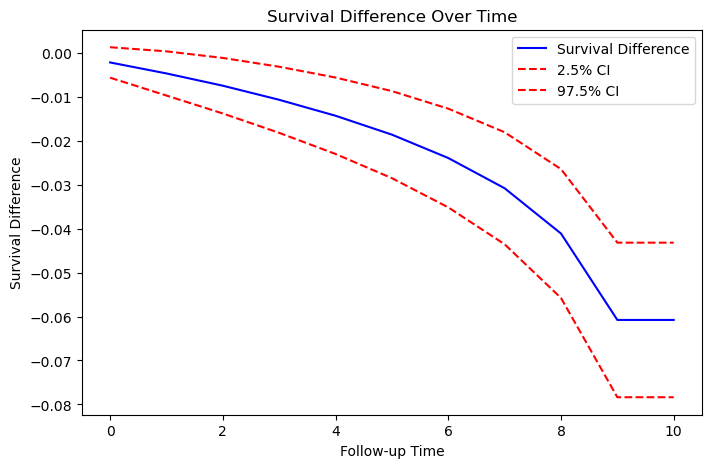

In [47]:
from lifelines import KaplanMeierFitter

# Step 1: Fit a Kaplan-Meier Survival Model for ITT trial
kmf_treated = KaplanMeierFitter()
kmf_control = KaplanMeierFitter()

# Subset data for assigned_treatment = 1 (treated) and 0 (control)
data_treated = expanded_data_itt[expanded_data_itt["assigned_treatment"] == 0]
data_control = expanded_data_itt[expanded_data_itt["assigned_treatment"] == 1]

# Fit Kaplan-Meier survival curves
kmf_treated.fit(data_treated["followup_time"], event_observed=data_treated["outcome"], label="Treated")
kmf_control.fit(data_control["followup_time"], event_observed=data_control["outcome"], label="Control")

# Step 2: Predict survival probabilities over time
followup_times = np.arange(0, 11)  # Predict for 0 to 10 follow-up periods
survival_treated = kmf_treated.survival_function_at_times(followup_times)
survival_control = kmf_control.survival_function_at_times(followup_times)

# Compute the survival difference
survival_diff = survival_treated - survival_control
# Step 3: Plot Survival Difference
plt.figure(figsize=(8, 5))
plt.plot(followup_times, survival_diff, label="Survival Difference", color="blue")

# Confidence intervals (assuming normal approximation)
std_error = np.sqrt(survival_treated * (1 - survival_treated) / len(data_treated) +
                    survival_control * (1 - survival_control) / len(data_control))

ci_lower = survival_diff - 1.96 * std_error
ci_upper = survival_diff + 1.96 * std_error

# Add confidence interval lines
plt.plot(followup_times, ci_lower, color="red", linestyle="dashed", label="2.5% CI")
plt.plot(followup_times, ci_upper, color="red", linestyle="dashed", label="97.5% CI")

# Labels and legend
plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.title("Survival Difference Over Time")
plt.legend()
plt.show()


In [48]:
data_censored = data_censored.rename(columns={'period': 'time'})

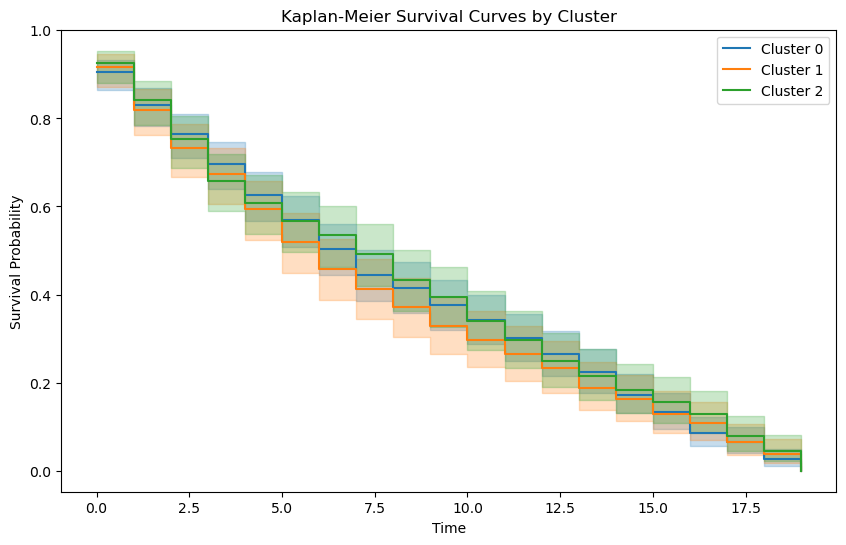

In [49]:
# -------------------------------
# Step 1: Preprocess Data
# -------------------------------
features = ['x1', 'x2', 'x3', 'x4']
scaled_features = StandardScaler().fit_transform(data_censored[features])

# -------------------------------
# Step 2: Apply K-Means Clustering
# -------------------------------
k = 3  # Adjust based on the optimal number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
data_censored['cluster'] = kmeans.fit_predict(scaled_features)

# -------------------------------
# Step 3: Compare Survival Across Clusters
# -------------------------------
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

for cluster in range(k):
    cluster_data = data_censored[data_censored['cluster'] == cluster]
    kmf.fit(cluster_data['time'], event_observed=1 - cluster_data['censored'], label=f'Cluster {cluster}')
    kmf.plot_survival_function()

plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Kaplan-Meier Survival Curves by Cluster")
plt.legend()
plt.show()
